

# 🧪 Modeling with Duke NIfTI 3D files

After downloading TCIA data and converting it to niftii files, Or downloading minimal croped niftii version from zendoo, We can start modeling on Duke data.
```
Author: Tomer Fridman
Date: 2025-04-01
Version: 1.0
Description: Module for using ML/DL on Duke niftii data
```

In [1279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import struct
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [1280]:
def show_pid(pid, df, show_bw=0, show_rgb=0):
    
    idx = df[df.pid==pid].index.values[0]
    
    r=df.loc[idx]
    pid=r['pid']
    print(pid)
    
    a0=ds.get_nifti_acquisition(pid, idx=0)
    a1=ds.get_nifti_acquisition(pid, idx=1)
    a2=ds.get_nifti_acquisition(pid, idx=r['post_late']) # last acqisition
    startm=int(r['mask_start'])
    endm=int(r['mask_end'])

    sraw=int(r['sraw'])
    eraw=int(r['eraw'])

    scol=int(r['scol'])
    ecol=int(r['ecol'])
    print(startm,endm,sraw,eraw,scol,ecol,a0.shape)
    m = np.zeros(a0.shape)
    m[startm:endm,sraw:eraw,scol:ecol]=1
    idx=[startm+1, (startm+endm)//2,endm-1]
    if show_rgb:
        ds.show_n_images([ds.to_rgb(a0[k],a1[k],a2[k]) for k in idx], axis_off=False)
    ds.show_n_images([np.stack([ds.minmax(a0[k]) ,
                                ds.minmax(a1[k]) ,
                                m[k]],axis=2 ) for k in idx])
    if show_bw:
        ds.show_n_images([a0[k] for k in idx], axis_off=False)
        ds.show_n_images([a1[k] for k in idx], axis_off=False)
        ds.show_n_images([a2[k] for k in idx], axis_off=False)

# Path setup

In [1281]:
my_computer=True
my_colab=False

# Root Directory where the nifti data will be places
base_path = "G:\\My Drive\\breast_mri"

In [1282]:
# Check if running in Google Colab

if 'google.colab' in str(get_ipython()):
    print("Running in Google Colab")
    # Clone the repository
    !git clone https://github.com/naomifridman/BreastDCEDL.git

    # Change to the repository directory
    os.chdir('/content/BreastDCEDL')
        
    my_colab = True    
    base_path='/content/BreastDCEDL'

In [1283]:
# setup directories of niftii data of I-SPY1, I-SPY2 and duke
    
nifti_path= {'spy2':os.path.join(base_path,"SPY2","vis1","dce"),
                        'spy1':os.path.join(base_path,"SPY1","vis1","dce"),
                        'duke':os.path.join(base_path,"DUKE","dce")}

mask_path={'spy2':os.path.join(base_path,"SPY2","vis1","mask"),
                    'spy1':os.path.join(base_path,"SPY1","vis1","mask"),
                    'duke':os.path.join(base_path,"DUKE","mask")}


In [1284]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../', 'utils')))

import data_utils as ds

ds.setup_paths(base_path, nifti_path, mask_path)

{'spy2': 'G:\\My Drive\\breast_mri\\SPY2\\vis1\\dce', 'spy1': 'G:\\My Drive\\breast_mri\\SPY1\\vis1\\dce', 'duke': 'G:\\My Drive\\breast_mri\\DUKE\\dce'} {'spy2': 'G:\\My Drive\\breast_mri\\SPY2\\vis1\\mask', 'spy1': 'G:\\My Drive\\breast_mri\\SPY1\\vis1\\mask', 'duke': 'G:\\My Drive\\breast_mri\\DUKE\\mask'}


In [1285]:
ds.show_pid('Breast_MRI_535',[0,1,2])

Breast_MRI_535 duke
no nifti files


In [1286]:
df = pd.read_csv('BreastDCEDL_duke_metadata.csv')

In [1287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pid                   922 non-null    object 
 1   n_xy                  922 non-null    int64  
 2   ER                    922 non-null    int64  
 3   PR                    922 non-null    int64  
 4   HER2                  922 non-null    int64  
 5   Mol_Subtype           922 non-null    int64  
 6   stage_tum_s           916 non-null    float64
 7   Tumor_Grade           907 non-null    float64
 8   Nottingham_grade      638 non-null    float64
 9   FOVcm                 922 non-null    int64  
 10  slice_thick           922 non-null    float64
 11  age                   922 non-null    int64  
 12  pCR                   300 non-null    float64
 13  HR                    922 non-null    int64  
 14  hormon_status         922 non-null    object 
 15  HR_HER2_STATUS        9

# Visualize niftii and tumor bounding box

In [1288]:
df.head(2)

pid  n_xy  ER  PR  HER2  Mol_Subtype  stage_tum_s  Tumor_Grade  \
0  Breast_MRI_001   448   0   0     1            2   2.00000000   3.00000000   
1  Breast_MRI_002   512   0   0     0            3   2.00000000   3.00000000   

   Nottingham_grade  FOVcm  ...         ecol  mask_start     mask_end  \
0        2.00000000     15  ... 341.00000000 89.00000000 112.00000000   
1        3.00000000      5  ... 136.00000000 59.00000000  72.00000000   

           n_z    n_times xy_spacing    voxel_z  pre  post_early  post_late  
0 160.00000000 5.00000000 0.80357140 1.10000002    0           1 4.00000000  
1 142.00000000 4.00000000 0.58590000 1.30000000    0           1 3.00000000  

[2 rows x 38 columns]

In [1289]:

r=df.iloc[200]
pid=r['pid']
print(pid)
a0=ds.get_nifti_acquisition(pid, idx=0)
a1=ds.get_nifti_acquisition(pid, idx=1)
a2=ds.get_nifti_acquisition(pid, idx=r['post_late']) # last acqisition

Breast_MRI_201


In [1290]:
startm=int(r['mask_start'])
endm=int(r['mask_end'])
        
sraw=int(r['sraw'])
eraw=int(r['eraw'])

scol=int(r['scol'])
ecol=int(r['ecol'])
startm,endm,sraw,eraw,scol,ecol,a0.shape

(96, 115, 136, 166, 72, 103, (176, 448, 448))

In [1291]:
# create binary mask from bounding box
m = np.zeros(a0.shape)
m[startm:endm,sraw:eraw,scol:ecol]=1
m.shape

(176, 448, 448)

<Figure size 640x480 with 0 Axes>

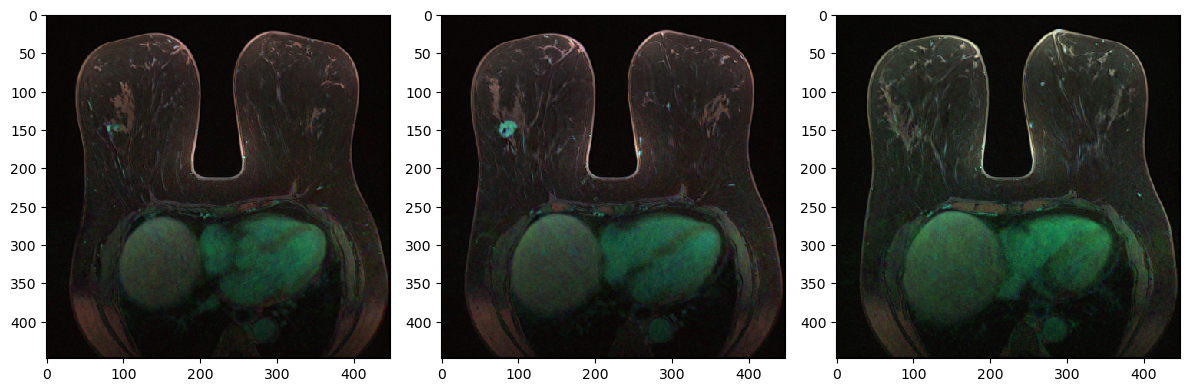

<Figure size 640x480 with 0 Axes>

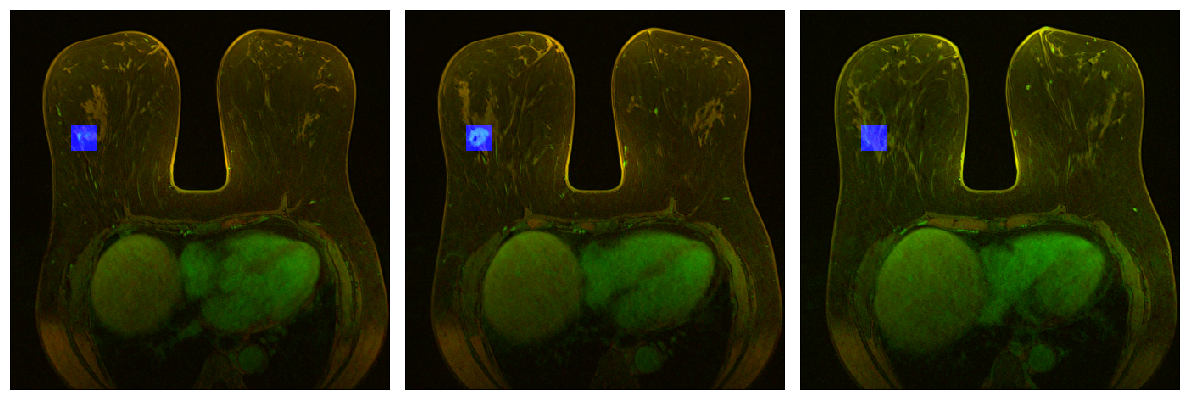

<Figure size 640x480 with 0 Axes>

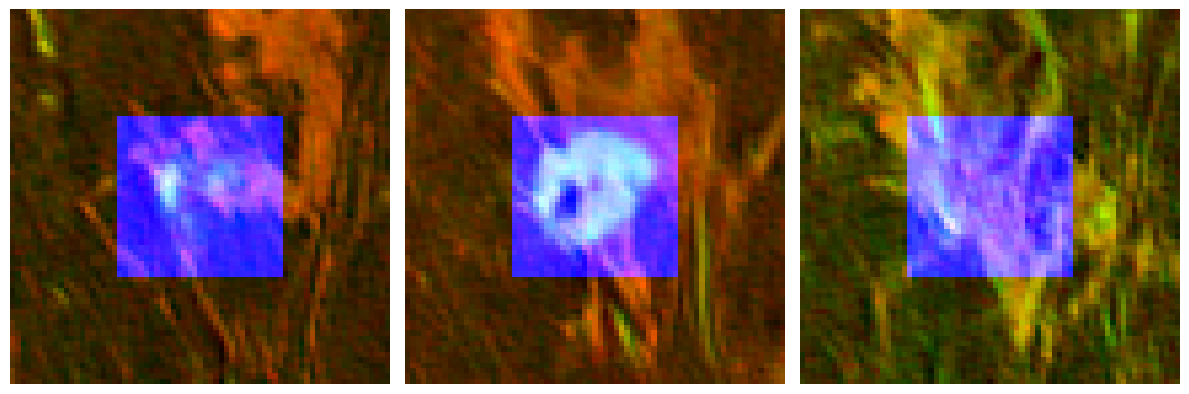

<Figure size 640x480 with 0 Axes>

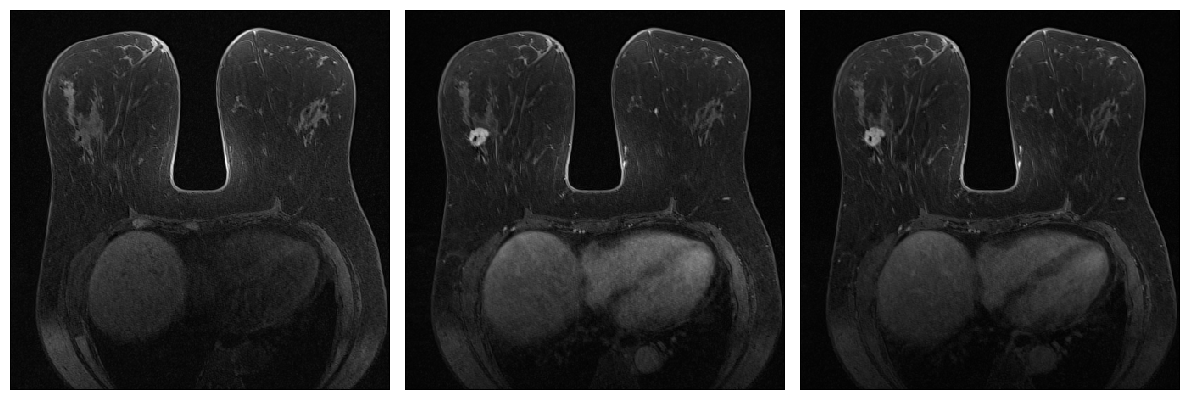

<Figure size 640x480 with 0 Axes>

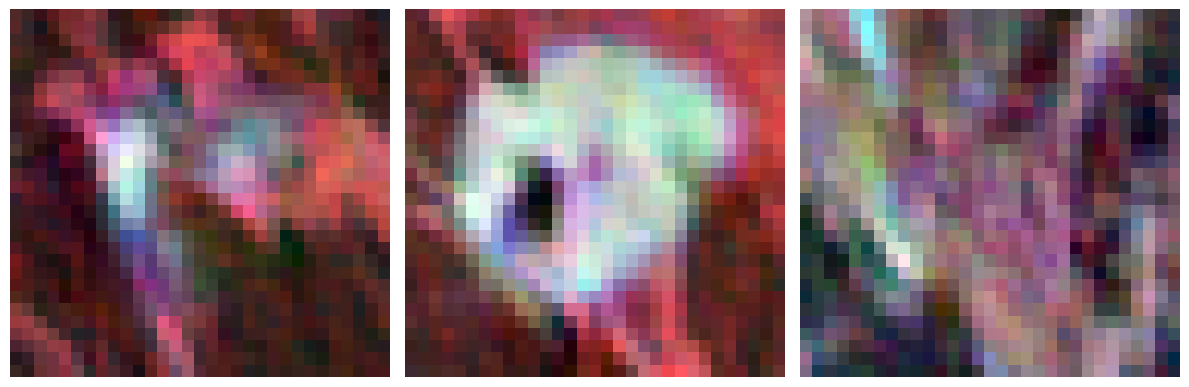

<Figure size 640x480 with 0 Axes>

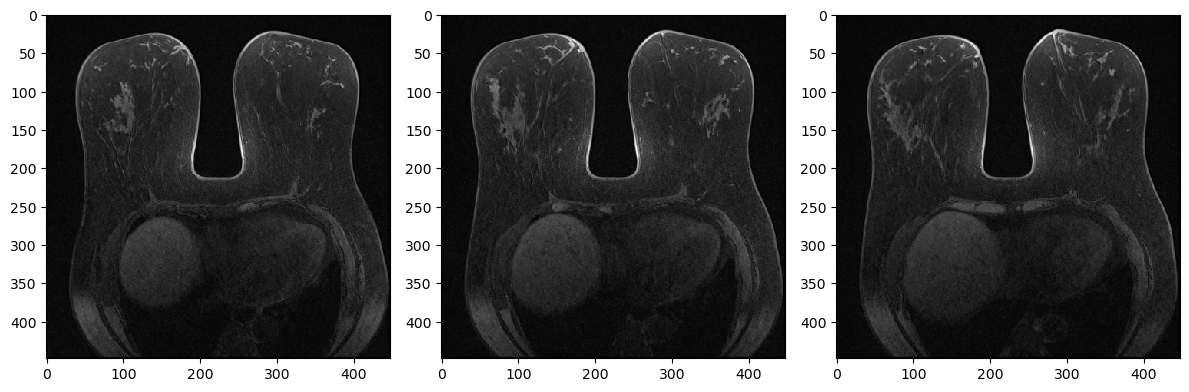

<Figure size 640x480 with 0 Axes>

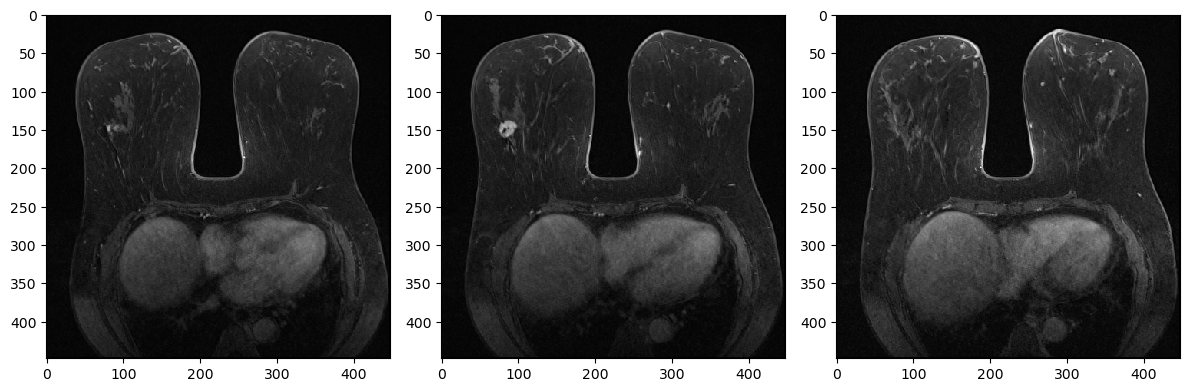

<Figure size 640x480 with 0 Axes>

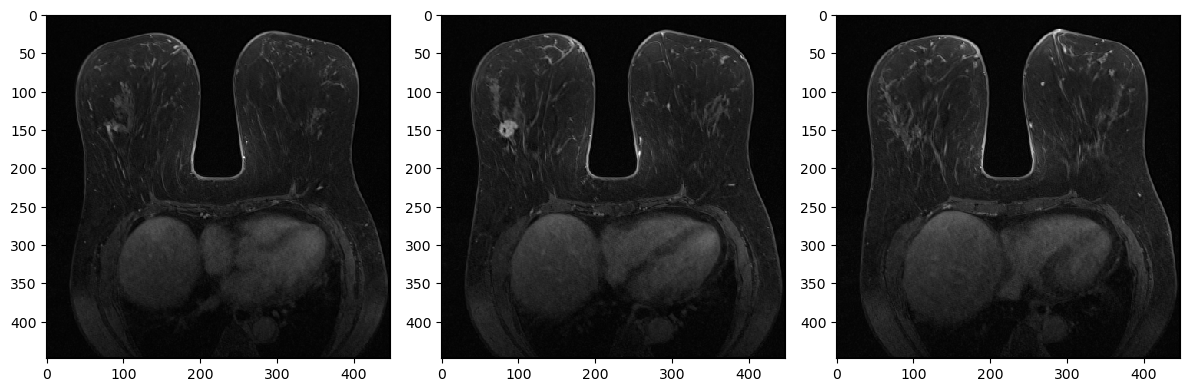

In [1292]:
idx=[startm+1, (startm+endm)//2,endm-1]
ds.show_n_images([ds.to_rgb(a0[k],a1[k],a2[k]) for k in idx], axis_off=False)
ds.show_n_images([np.stack([ds.minmax(a0[k]) ,
                            ds.minmax(a1[k]) ,
                            m[k]],axis=2 ) for k in idx])
ds.show_n_images([np.stack([ds.minmax(a0[k,sraw-20:eraw+20,scol-20:ecol+20]) ,
                            ds.minmax(a1[k,sraw-20:eraw+20,scol-20:ecol+20]) ,
                            m[k,sraw-20:eraw+20,scol-20:ecol+20]],axis=2 ) for k in idx])
ds.show_n_images([ds.minmax(a0[idx[1]]), 
                                ds.minmax(a1[idx[1]]), 
                                             ds.minmax(a2[idx[1]])]) 

ds.show_n_images([ds.to_rgb(a0[k,sraw:eraw,scol:ecol],
                            a1[k,sraw:eraw,scol:ecol],
                            a2[k,sraw:eraw,scol:ecol])  for k in idx])
ds.show_n_images([a0[k] for k in idx], axis_off=False)
ds.show_n_images([a1[k] for k in idx], axis_off=False)
ds.show_n_images([a2[k] for k in idx], axis_off=False)

In [1293]:
df[df.pid=='Breast_MRI_244']

pid  n_xy  ER  PR  HER2  Mol_Subtype  stage_tum_s  \
243  Breast_MRI_244   512   1   1     1            1   4.00000000   

     Tumor_Grade  Nottingham_grade  FOVcm  ...         ecol  mask_start  \
243   2.00000000               NaN      5  ... 429.00000000 45.00000000   

       mask_end          n_z    n_times xy_spacing    voxel_z  pre  \
243 73.00000000 156.00000000 5.00000000 0.58590000 1.00000000    0   

     post_early  post_late  
243           1 4.00000000  

[1 rows x 38 columns]

In [1294]:
df[df.pid=='Breast_MRI_517']

pid  n_xy  ER  PR  HER2  Mol_Subtype  stage_tum_s  \
516  Breast_MRI_517   512   0   1     0            0   4.00000000   

     Tumor_Grade  Nottingham_grade  FOVcm  ...         ecol  mask_start  \
516   3.00000000               NaN     14  ... 380.00000000 66.00000000   

       mask_end          n_z    n_times xy_spacing    voxel_z  pre  \
516 97.00000000 142.00000000 5.00000000 0.68360000 1.00000000    0   

     post_early  post_late  
516           1 4.00000000  

[1 rows x 38 columns]

In [1295]:

r=df.iloc[516]
pid=r['pid']
print(pid)
a0=ds.get_nifti_acquisition(pid, idx=0)
a1=ds.get_nifti_acquisition(pid, idx=1)
a2=ds.get_nifti_acquisition(pid, idx=r['post_late']) # last acqisition
r['post_late']

Breast_MRI_517


4.0

In [1296]:
startm=int(r['mask_start'])
endm=int(r['mask_end'])
        
sraw=int(r['sraw'])
eraw=int(r['eraw'])

scol=int(r['scol'])
ecol=int(r['ecol'])
startm,endm,sraw,eraw,scol,ecol,a0.shape

(66, 97, 318, 376, 312, 380, (142, 512, 512))

In [1297]:
# create binary mask from bounding box
m = np.zeros(a0.shape)
m[startm:endm,sraw:eraw,scol:ecol]=1
m.shape

(142, 512, 512)

In [1298]:
a0=ds.get_nifti_acquisition(pid, idx=0)
a1=ds.get_nifti_acquisition(pid, idx=1)
a2=ds.get_nifti_acquisition(pid, idx=4)
ds.print_info([a0[81],a1[81],a2[81]])

(512, 512) 0.0 4014.0 195.90724182128906 313.3524937408402 n!=0: 170916 300.47454890121463 float64
(512, 512) 0.0 7094.0 316.31958389282227 561.5819824616793 n!=0: 167046 496.3978844150713 float64
(512, 512) 0.0 6025.0 335.30158615112305 568.9771956645776 n!=0: 165532 530.9988340622962 float64


In [1299]:
a0=ds.get_nifti_acquisition(pid, idx=0)
a1=ds.get_nifti_acquisition(pid, idx=1)
a2=ds.get_nifti_acquisition(pid, idx=4)
a0=ds.minmax(a0.clip(0,4000))
a1=ds.minmax(a1.clip(0,4000))
a2=ds.minmax(a2.clip(0,4000))

<Figure size 640x480 with 0 Axes>

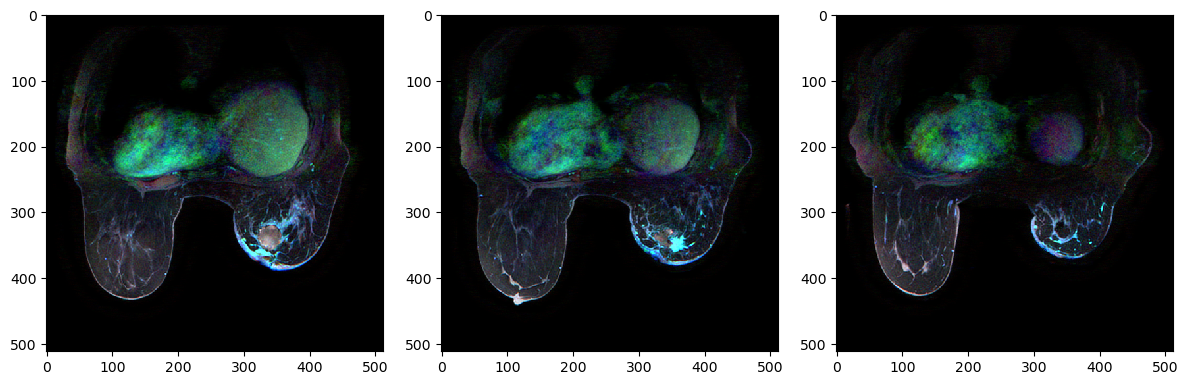

<Figure size 640x480 with 0 Axes>

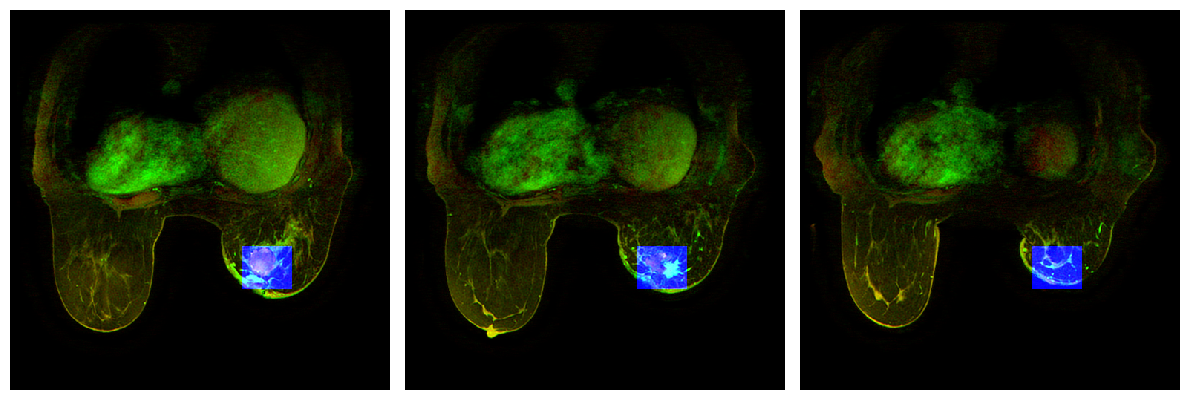

<Figure size 640x480 with 0 Axes>

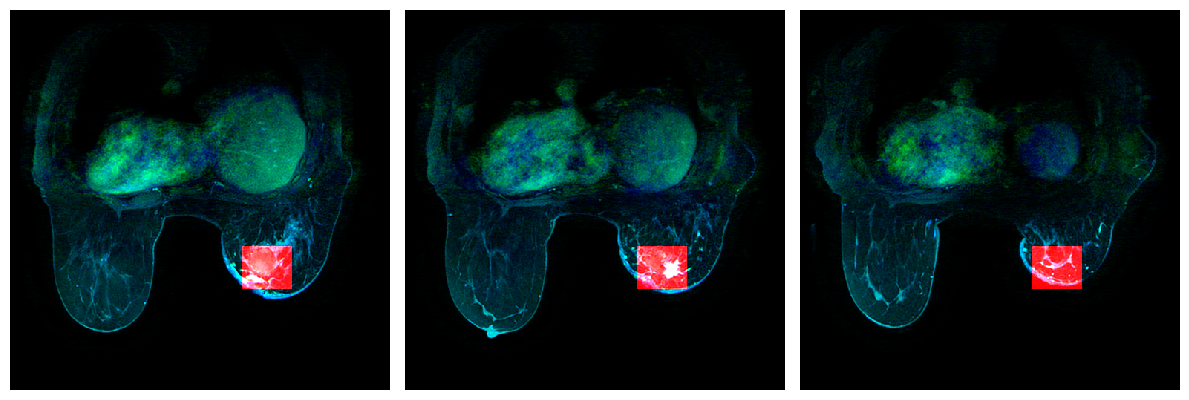

<Figure size 640x480 with 0 Axes>

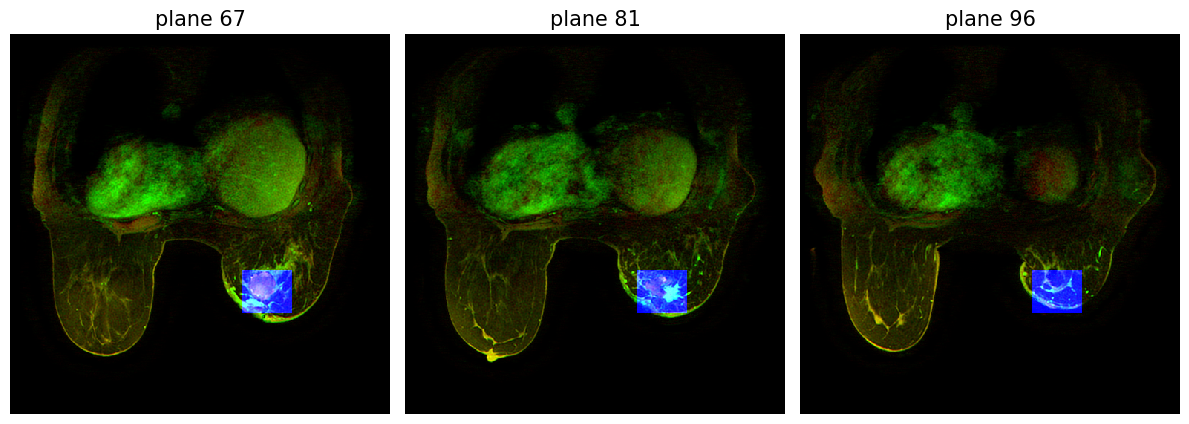

<Figure size 640x480 with 0 Axes>

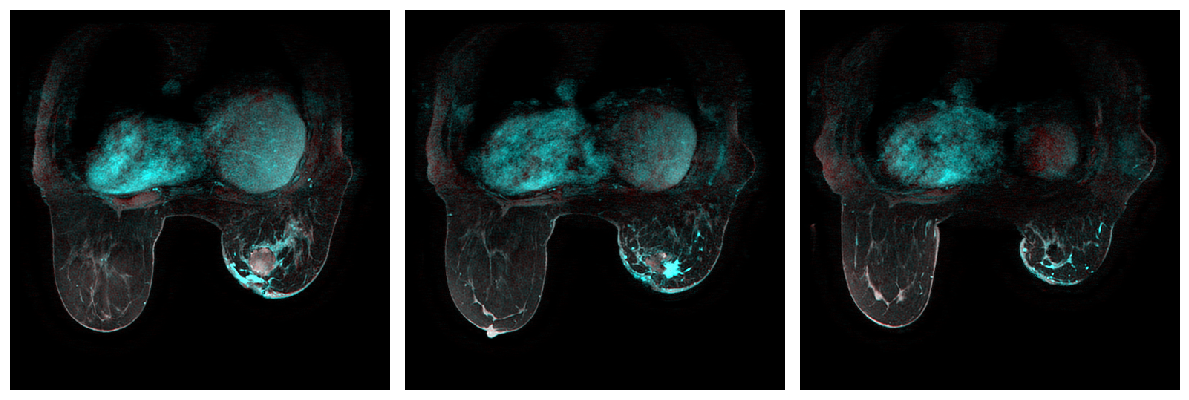

<Figure size 640x480 with 0 Axes>

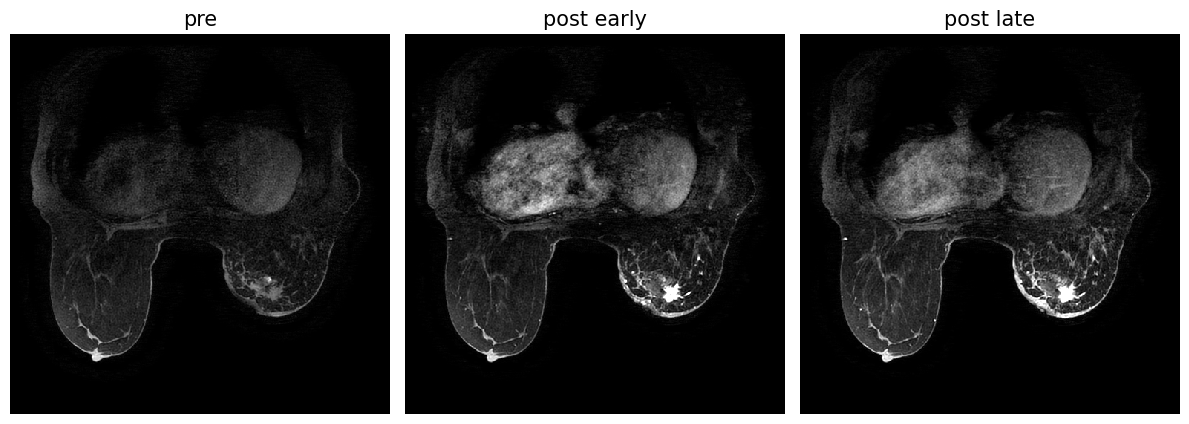

<Figure size 640x480 with 0 Axes>

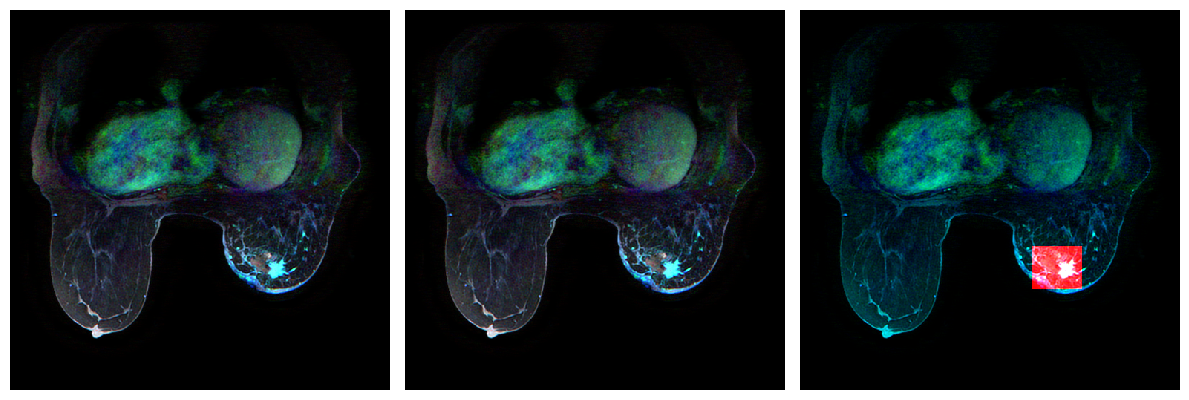

In [1300]:
idx=[startm+1, (startm+endm)//2,endm-1]
ds.show_n_images([ds.to_rgb(a0[k],a1[k],a2[k]) for k in idx], axis_off=False)
ds.show_n_images([np.stack([ds.minmax(a0[k]) ,
                            ds.minmax(a1[k]) ,
                            m[k]],axis=2 ) for k in idx])
ds.show_n_images([np.stack([m[k],ds.minmax(a1[k]) ,
                            ds.minmax(a2[k]) ,
                            ],axis=2 ) for k in idx])

ds.show_n_images([np.stack([ds.minmax(a0[k]) ,
                            ds.minmax(a1[k]) ,
                            m[k]],axis=2 ) for k in idx], titles=['plane '+str(k) for k in idx])
ds.show_n_images([np.stack([ds.minmax(a0[k]) ,
                            ds.minmax(a1[k]) ,
                            ds.minmax(a1[k])],axis=2 ) for k in idx])
k=(startm+endm)//2
ds.show_n_images([ds.minmax(a0[k]), 
                                ds.minmax(a1[k]), 
                                             ds.minmax(a2[k])], titles=['pre','post early','post late']) 



ds.show_n_images([ds.to_rgb(a0[k],a1[k],a2[k]),ds.to_rgb(a0[k],a1[k],a2[k]),np.stack([m[k],ds.minmax(a1[k]) ,
                            ds.minmax(a2[k]) ,
                            ],axis=2 ) ])

In [1301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pid                   922 non-null    object 
 1   n_xy                  922 non-null    int64  
 2   ER                    922 non-null    int64  
 3   PR                    922 non-null    int64  
 4   HER2                  922 non-null    int64  
 5   Mol_Subtype           922 non-null    int64  
 6   stage_tum_s           916 non-null    float64
 7   Tumor_Grade           907 non-null    float64
 8   Nottingham_grade      638 non-null    float64
 9   FOVcm                 922 non-null    int64  
 10  slice_thick           922 non-null    float64
 11  age                   922 non-null    int64  
 12  pCR                   300 non-null    float64
 13  HR                    922 non-null    int64  
 14  hormon_status         922 non-null    object 
 15  HR_HER2_STATUS        9

## Box and Tumor volume is importent, check and calculate

data is given in mm except tum vol which is given in cm.

In [1303]:
for i,row in df.iterrows():
        p=row['pid']
        mc1 = -row['mask_start']+row['mask_end']+1
        mc2=-row['sraw']+row['eraw']+1
        mc3=-row['scol']+row['ecol']+1
        
        df.at[i,'bbox_z']=row['slice_thick']*(mc1)/10.
        df.at[i,'bbox_x']=row['xy_spacing']*(mc2)/10.
        df.at[i,'bbox_y']=row['xy_spacing']*(mc3)/10.
        
        df.at[i,'bbox_vol']=row['slice_thick']*row['xy_spacing']*row['xy_spacing']*(mc1*mc2*mc3)/1000.
        df.at[i,'bbox_count']=(mc1*mc2*mc3)
        df.at[i,'voxel_vol']=row['slice_thick']*row['xy_spacing']*row['xy_spacing']/1000
df.at[i,'tum_vol_s']=df['stage_tum_s']

In [1304]:
x=pd.read_csv('../BreastDCEDL_metadata.csv')
df=df.merge(x[['pid','tum_vol','test']],on='pid',how='left')

In [1367]:
df[['tum_vol','bbox_vol','stage_tum_s','tum_vol_tcia_imaging']].describe()

tum_vol      bbox_vol  stage_tum_s  tum_vol_tcia_imaging
count    298.00000000  298.00000000 296.00000000          298.00000000
mean   29031.35147655  167.40546283   2.05405405           15.46427866
std    48772.04699436  340.30598067   0.77489231           25.61774037
min      520.61495500    1.52361413   1.00000000            0.06543281
25%     6406.01585190   22.75421544   2.00000000            2.90942745
50%    15458.57408838   57.54974929   2.00000000            6.23096940
75%    29810.82701679  154.85403577   2.00000000           16.60420412
max   495008.42335542 3967.64820238   4.00000000          158.65125630

In [1369]:
df[['tum_vol','bbox_vol','stage_tum_s','tum_vol_tcia_imaging']].head(20)

tum_vol      bbox_vol  stage_tum_s  tum_vol_tcia_imaging
0   31107.11019150   22.02497309   2.00000000            5.52684208
1   15828.58592910    7.97203246   2.00000000            1.27943445
2   35923.97460938   43.69151852   2.00000000            2.44262393
4   78851.40380859   61.15966797   2.00000000           10.00610352
8   70510.78405280   31.78582839   2.00000000            5.23990739
9    5201.31737362   97.40738709   3.00000000           12.49434619
11   9412.10937500  696.90859141   2.00000000          103.02662153
18 119868.98438514   55.98020313   1.00000000           12.60175496
20  10156.80821714   26.41487900   1.00000000            3.24236690
21  18741.28189087   39.32757941   2.00000000            4.26329305
27  22801.17187500  599.70703125   4.00000000          110.29052734
31   5451.64532617   33.78864384   2.00000000            3.58857689
39  95102.13899800   84.44219318   3.00000000           12.50350179
40  64717.63763428   80.93043493   2.00000000            4.54271040
42  24133.95022036   53.50313745   4.00000000            9.32701953
43  54503.22239742   12.41796959   1.00000000            3.69371246
44   4168.65234375  119.19685648   2.00000000           12.24957520
45   3394.27101831 1147.64816127   4.00000000           38.08290364
47  92380.29805976   18.36085503   1.00000000            1.68759976
50   4202.88399414   11.20010260   2.00000000            0.37733968

In [1306]:
df[df.tum_vol>300]

pid  n_xy  ER  PR  HER2  Mol_Subtype  stage_tum_s  \
0    Breast_MRI_001   448   0   0     1            2   2.00000000   
1    Breast_MRI_002   512   0   0     0            3   2.00000000   
2    Breast_MRI_003   512   1   1     0            0   2.00000000   
4    Breast_MRI_005   448   1   0     1            1   2.00000000   
8    Breast_MRI_009   512   0   0     0            3   2.00000000   
..              ...   ...  ..  ..   ...          ...          ...   
906  Breast_MRI_907   448   0   0     1            2   2.00000000   
913  Breast_MRI_914   512   0   0     0            3   2.00000000   
914  Breast_MRI_915   512   1   0     0            0   2.00000000   
915  Breast_MRI_916   512   1   1     0            0   1.00000000   
916  Breast_MRI_917   512   0   0     0            3   2.00000000   

     Tumor_Grade  Nottingham_grade  FOVcm  ...  post_late     bbox_z  \
0     3.00000000        2.00000000     15  ... 4.00000000 2.64000000   
1     3.00000000        3.00000000      5  ... 3.00000000 1.82000000   
2     3.00000000               NaN     14  ... 4.00000000 2.60000000   
4     3.00000000        3.00000000     14  ... 3.00000000 9.40000000   
8     3.00000000        3.00000000     11  ... 3.00000000 2.86000000   
..           ...               ...    ...  ...        ...        ...   
906   3.00000000        2.00000000     11  ... 4.00000000 5.06000000   
913   3.00000000        3.00000000     11  ... 3.00000000 6.60000000   
914   2.00000000        3.00000000     14  ... 3.00000000 6.20000000   
915   3.00000000        3.00000000     11  ... 3.00000000 1.82000000   
916   3.00000000        2.00000000     15  ... 3.00000000 8.91000000   

        bbox_x     bbox_y     bbox_vol       bbox_count  voxel_vol  tum_vol_s  \
0   3.05357133 2.73214277  22.02497309   31008.00000000 0.00071030 2.00000000   
1   2.57796000 1.69911000   7.97203246   17864.00000000 0.00044626 2.00000000   
2   4.23832000 3.96488000  43.69151852   46748.00000000 0.00093462 2.00000000   
4   2.03125000 3.20312500  61.15966797   50102.00000000 0.00122070 2.00000000   
8   3.71896000 2.98845000  31.78582839   65520.00000000 0.00048513 2.00000000   
..         ...        ...          ...              ...        ...        ...   
906 5.46428590 6.14732164 169.96905800  268272.00000000 0.00063357 2.00000000   
913 4.51588000 3.85178000 114.80156336  130152.00000000 0.00088206 2.00000000   
914 6.42584000 4.23832000 168.85555037  180668.00000000 0.00093462 2.00000000   
915 1.85948000 1.79307000   6.06820360   10584.00000000 0.00057334 1.00000000   
916 8.01534000 7.66379000 547.32243342 1006506.00000000 0.00054378 2.00000000   

           tum_vol       test  
0   31107.11019150 0.00000000  
1   15828.58592910 1.00000000  
2   35923.97460938 0.00000000  
4   78851.40380859 0.00000000  
8   70510.78405280 0.00000000  
..             ...        ...  
906 37304.07574046 1.00000000  
913  6459.56697958 0.00000000  
914 39878.90625000 2.00000000  
915  4549.30533901 0.00000000  
916 22353.77794219 1.00000000  

[298 rows x 47 columns]

Breast_MRI_535
23 130 218 418 54 223 (160, 512, 512)


<Figure size 640x480 with 0 Axes>

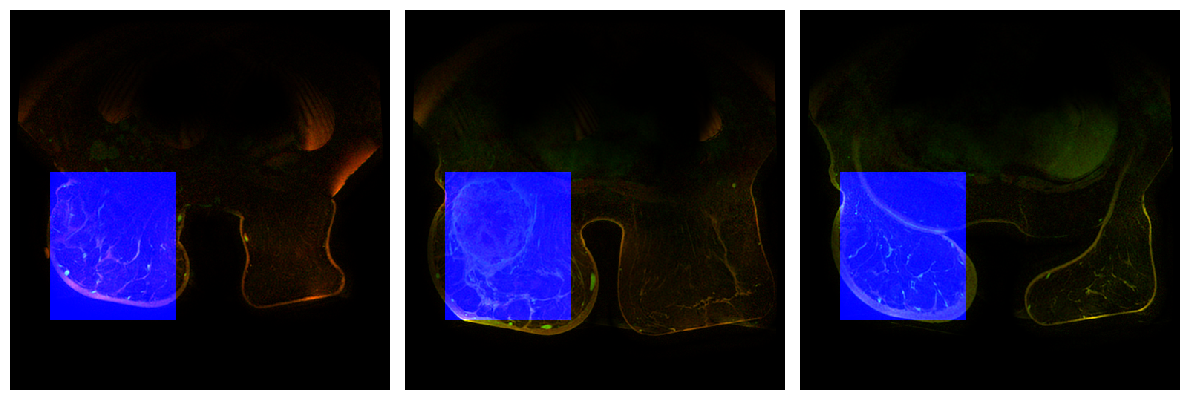

In [1307]:
show_pid('Breast_MRI_535',df)

In [1308]:
df[~df.tum_vol.isna()][['pid','pCR','tum_vol','bbox_vol']]

pid        pCR        tum_vol    bbox_vol
0    Breast_MRI_001 0.00000000 31107.11019150 22.02497309
1    Breast_MRI_002 0.00000000 15828.58592910  7.97203246
2    Breast_MRI_003 0.00000000 35923.97460938 43.69151852
3    Breast_MRI_004        NaN     1.00000000  2.25423422
4    Breast_MRI_005 1.00000000 78851.40380859 61.15966797
..              ...        ...            ...         ...
917  Breast_MRI_918        NaN     2.00000000 72.98543491
918  Breast_MRI_919        NaN     1.00000000  9.45424639
919  Breast_MRI_920        NaN     1.00000000  7.22269660
920  Breast_MRI_921        NaN     2.00000000 37.01035210
921  Breast_MRI_922        NaN     2.00000000  2.26214382

[912 rows x 4 columns]

In [1309]:
df[df.bbox_vol<3][['tum_vol','bbox_vol']]

tum_vol   bbox_vol
3   1.00000000 2.25423422
6   1.00000000 1.98999023
13  1.00000000 1.81320142
23  1.00000000 0.31644675
36  2.00000000 1.42061563
..         ...        ...
891 1.00000000 2.41169378
892        NaN 1.33897951
896 1.00000000 0.34639077
912 1.00000000 2.57393775
921 2.00000000 2.26214382

[85 rows x 2 columns]

## impute

df.at[126, 'tum_vol'] = 0.75

Breast_MRI_127
99 106 151 177 92 112 (160, 448, 448)


<Figure size 640x480 with 0 Axes>

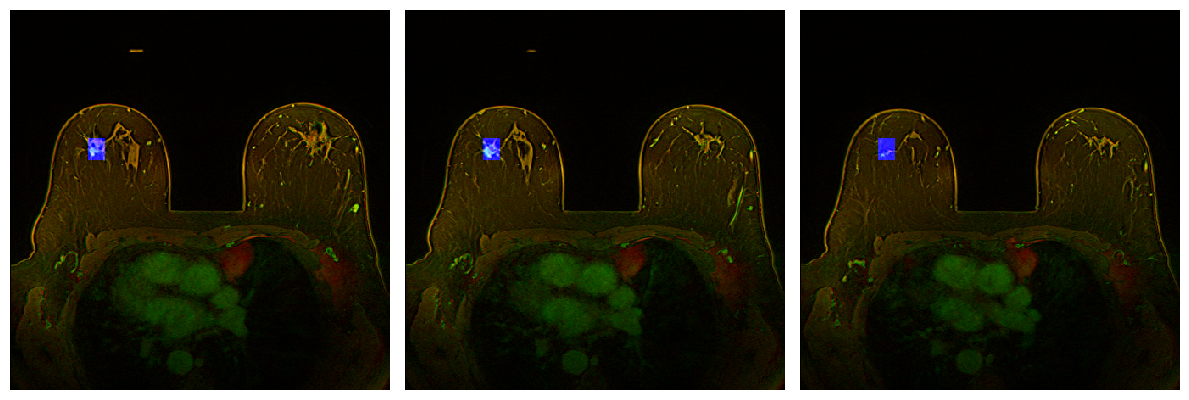

In [1310]:
show_pid('Breast_MRI_127', df)

In [1311]:
for c in ['Nottingham_grade','hist_type', 'Tumor_Grade']:
    print(df[c].value_counts())

Nottingham_grade
2.00000000    318
3.00000000    207
1.00000000    113
Name: count, dtype: int64
hist_type
IDC     575
ILC      63
rare      8
Name: count, dtype: int64
Tumor_Grade
3.00000000    695
2.00000000    144
1.00000000     68
Name: count, dtype: int64


In [1312]:
df_bin = pd.get_dummies(df["hist_type"])
df_bin.astype(int)

IDC  ILC  rare
0      1    0     0
1      1    0     0
2      0    0     0
3      1    0     0
4      1    0     0
..   ...  ...   ...
917    1    0     0
918    1    0     0
919    0    1     0
920    1    0     0
921    1    0     0

[922 rows x 3 columns]

In [1313]:
# Concatenate with original DataFrame
df = pd.concat([df, df_bin.astype(int)], axis=1)
df.head()

pid  n_xy  ER  PR  HER2  Mol_Subtype  stage_tum_s  Tumor_Grade  \
0  Breast_MRI_001   448   0   0     1            2   2.00000000   3.00000000   
1  Breast_MRI_002   512   0   0     0            3   2.00000000   3.00000000   
2  Breast_MRI_003   512   1   1     0            0   2.00000000   3.00000000   
3  Breast_MRI_004   512   1   1     0            0   1.00000000   3.00000000   
4  Breast_MRI_005   448   1   0     1            1   2.00000000   3.00000000   

   Nottingham_grade  FOVcm  ...     bbox_y    bbox_vol     bbox_count  \
0        2.00000000     15  ... 2.73214277 22.02497309 31008.00000000   
1        3.00000000      5  ... 1.69911000  7.97203246 17864.00000000   
2               NaN     14  ... 3.96488000 43.69151852 46748.00000000   
3        2.00000000     15  ... 0.84372000  2.25423422  2280.00000000   
4        3.00000000     14  ... 3.20312500 61.15966797 50102.00000000   

   voxel_vol  tum_vol_s        tum_vol       test  IDC  ILC  rare  
0 0.00071030 2.00000000 31107.11019150 0.00000000    1    0     0  
1 0.00044626 2.00000000 15828.58592910 1.00000000    1    0     0  
2 0.00093462 2.00000000 35923.97460938 0.00000000    0    0     0  
3 0.00098870 1.00000000     1.00000000 1.00000000    1    0     0  
4 0.00122070 2.00000000 78851.40380859 0.00000000    1    0     0  

[5 rows x 50 columns]

In [1314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pid                   922 non-null    object 
 1   n_xy                  922 non-null    int64  
 2   ER                    922 non-null    int64  
 3   PR                    922 non-null    int64  
 4   HER2                  922 non-null    int64  
 5   Mol_Subtype           922 non-null    int64  
 6   stage_tum_s           916 non-null    float64
 7   Tumor_Grade           907 non-null    float64
 8   Nottingham_grade      638 non-null    float64
 9   FOVcm                 922 non-null    int64  
 10  slice_thick           922 non-null    float64
 11  age                   922 non-null    int64  
 12  pCR                   300 non-null    float64
 13  HR                    922 non-null    int64  
 14  hormon_status         922 non-null    object 
 15  HR_HER2_STATUS        9

In [1315]:
df[df.pCR.isna()].tum_vol

3     1.00000000
5     1.00000000
6     1.00000000
7     1.00000000
10    1.00000000
         ...    
917   2.00000000
918   1.00000000
919   1.00000000
920   2.00000000
921   2.00000000
Name: tum_vol, Length: 622, dtype: float64

In [1316]:
df[~df.pCR.isna()].tum_vol

0     31107.11019150
1     15828.58592910
2     35923.97460938
4     78851.40380859
8     70510.78405280
           ...      
906   37304.07574046
913    6459.56697958
914   39878.90625000
915    4549.30533901
916   22353.77794219
Name: tum_vol, Length: 300, dtype: float64

In [1317]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pid                   922 non-null    object 
 1   n_xy                  922 non-null    int64  
 2   ER                    922 non-null    int64  
 3   PR                    922 non-null    int64  
 4   HER2                  922 non-null    int64  
 5   Mol_Subtype           922 non-null    int64  
 6   stage_tum_s           916 non-null    float64
 7   Tumor_Grade           907 non-null    float64
 8   Nottingham_grade      638 non-null    float64
 9   FOVcm                 922 non-null    int64  
 10  slice_thick           922 non-null    float64
 11  age                   922 non-null    int64  
 12  pCR                   300 non-null    float64
 13  HR                    922 non-null    int64  
 14  hormon_status         922 non-null    object 
 15  HR_HER2_STATUS        9

# harmonize with BreastDCEDL metadata

In [1318]:

df['dataset']='duke'

## Add dl predictions

In [1319]:
dd.shape

(2070, 30)

In [1320]:
dd=pd.read_csv('../BreastDCEDL_vit_pcr_predictions.csv')
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452 entries, 0 to 1451
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pid               1452 non-null   object 
 1   DL_pred_pcr_mean  1452 non-null   float64
 2   DL_pred_pcr_min   1452 non-null   float64
dtypes: float64(2), object(1)
memory usage: 34.2+ KB


In [1321]:
df = df.merge(dd[["pid", "DL_pred_pcr_mean","DL_pred_pcr_min"]], on="pid", how="left");
df.test=df.test.fillna(0)

In [1322]:
df.columns

Index(['pid', 'n_xy', 'ER', 'PR', 'HER2', 'Mol_Subtype', 'stage_tum_s',
       'Tumor_Grade', 'Nottingham_grade', 'FOVcm', 'slice_thick', 'age', 'pCR',
       'HR', 'hormon_status', 'HR_HER2_STATUS', 'TripleNeg', 'HER2pos',
       'HRposHER2neg', 'menopause', 'race_white', 'race_black', 'hist_type',
       'bilateral', 'tum_vol_tcia_imaging', 'sraw', 'eraw', 'scol', 'ecol',
       'mask_start', 'mask_end', 'n_z', 'n_times', 'xy_spacing', 'voxel_z',
       'pre', 'post_early', 'post_late', 'bbox_z', 'bbox_x', 'bbox_y',
       'bbox_vol', 'bbox_count', 'voxel_vol', 'tum_vol_s', 'tum_vol', 'test',
       'IDC', 'ILC', 'rare', 'dataset', 'DL_pred_pcr_mean', 'DL_pred_pcr_min'],
      dtype='object')

In [1323]:
df['box_to_tum']=df['bbox_vol']/df['tum_vol']

In [1324]:
df=df[~df.pCR.isna()]

In [1332]:
df=df[~df.DL_pred_pcr_mean.isna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 298 entries, 0 to 916
Data columns (total 54 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pid                   298 non-null    object 
 1   n_xy                  298 non-null    int64  
 2   ER                    298 non-null    int64  
 3   PR                    298 non-null    int64  
 4   HER2                  298 non-null    int64  
 5   Mol_Subtype           298 non-null    int64  
 6   stage_tum_s           296 non-null    float64
 7   Tumor_Grade           294 non-null    float64
 8   Nottingham_grade      197 non-null    float64
 9   FOVcm                 298 non-null    int64  
 10  slice_thick           298 non-null    float64
 11  age                   298 non-null    int64  
 12  pCR                   298 non-null    float64
 13  HR                    298 non-null    int64  
 14  hormon_status         298 non-null    object 
 15  HR_HER2_STATUS        298 no

In [1333]:
df_test=df[df.test==1]
df_valid=df[df.test==2]
df_train=df[df.test==0]
df_val_train=df[df.test!=1]

(255, 17)

 Test  Accuracy:  0.767  AUC:  0.644   Specificity: 0.824   Sensitivity: 0.556 NPV: 0.875 Precision: 0.455
   No  Yes
0  28    6
1   4    5
Random Forest Results:
AUC: 0.6438
Accuracy: 0.7674
F1-score: 0.5000

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85        34
         1.0       0.45      0.56      0.50         9

    accuracy                           0.77        43
   macro avg       0.66      0.69      0.67        43
weighted avg       0.79      0.77      0.78        43



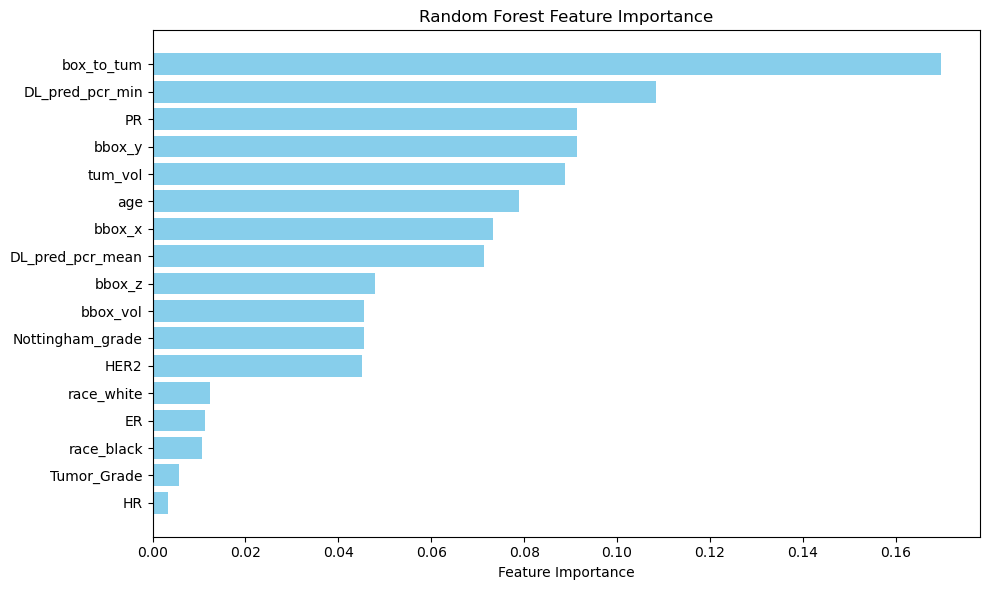

In [1372]:
  
    X_train = df_val_train[pcols].fillna(0).values
    y_train = df_val_train['pCR'].values
    print(X_train.shape)
    X_test = df_test[pcols].fillna(0).values
    y_test=df_test.pCR.values
    X_test.shape,y_test
    
    # Standardize features
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 1. Random Forest
    rf_model = GradientBoostingClassifier(
        n_estimators=600,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
    )

    # Train Random Forest
    rf_model.fit(X_train_scaled, y_train)

    # Make predictions with Random Forest
    rf_pred = rf_model.predict(X_test_scaled)
    rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics for Random Forest
    rf_auc = roc_auc_score(y_test, rf_pred_proba)
    rf_f1 = f1_score(y_test, rf_pred)
    rf_accuracy = accuracy_score(y_test, rf_pred)


    ds.report_full(y=y_test, y_pred=rf_pred_proba, tlt='Test',
                plot_roc_c=0)
    # Print Random Forest results
    print("Random Forest Results:")
    print(f"AUC: {rf_auc:.4f}")
    print(f"Accuracy: {rf_accuracy:.4f}")
    print(f"F1-score: {rf_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, rf_pred))
    
    if 1:
        # Create a DataFrame for feature importance
        importance_df = pd.DataFrame({
            'feature': pcols, 
            'importance': rf_model.feature_importances_
        })

        # Sort features by importance in descending order.
        importance_df.sort_values('importance', ascending=False, inplace=True)

        # Create a horizontal bar plot
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
        plt.xlabel("Feature Importance")
        plt.title("Random Forest Feature Importance")
        plt.gca().invert_yaxis()  # Highest importance at the top
        plt.tight_layout()
        plt.show()
    

## Lets try the imaging feature excel

In [774]:
dd = pd.read_excel(os.path.join('TCIA_metadata',
                              "Imaging_Features.xlsx"))


In [775]:
dd=dd.rename(columns={'Patient ID':'pid'})


In [776]:
cc=[p for p in dd.columns]

In [777]:
df = df.merge(dd[cc], on="pid", how="left")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Columns: 585 entries, pid to WashinRate_map_kurtosis_tissue_PostCon
dtypes: float64(558), int32(3), int64(19), object(5)
memory usage: 1.2+ MB


In [892]:
cols=[c for c in cc if 'std' not in c][1:]
cols=[c for c in cols if 'variance' not in c][1:]
pcols+cols

['ER',
 'PR',
 'HER2',
 'stage_tum_s',
 'Tumor_Grade',
 'Nottingham_grade',
 'box_to_tum',
 'slice_thick',
 'voxel_z',
 'age',
 'box_to_tum',
 'race_white',
 'race_black',
 'tum_vol',
 'IDC',
 'ILC',
 'rare',
 'box_w',
 'box_h_cm',
 'bbox_vol',
 'DL_pred_pcr_mean',
 'DL_pred_pcr_min',
 'F1_DT_POSTCON (T11=0.05,T12=0.5)',
 'F1_DT_POSTCON (T11=0.05,T12=0.1)',
 'F1_DT_POSTCON (T11=0.02,T12=0.5)',
 'F1_DT_POSTCON (T11=0.02,T12=0.8)',
 'F1_DT_POSTCON (T11=0.05,T12=0.8)',
 'F1_DT_POSTCON (T11=0.1,T12=0.5)',
 'F1_DT_POSTCON (T11=0.1,T12=0.8)',
 'F1_DT_POSTCON (T11=0.2,T12=0.5)',
 'F1_DT_POSTCON (T11=0.2,T12=0.8)',
 'F1_DT_T1NFS (T11=0.05,T12=0.5)',
 'F1_DT_T1NFS(T11=0.05,T12=0.1)',
 'F1_DT_T1NFS (T11=0.02,T12=0.5)',
 'F1_DT_T1NFS (T11=0.02,T12=0.8)',
 'F1_DT_T1NFS (T11=0.05,T12=0.8)',
 'F1_DT_T1NFS (T11=0.1,T12=0.5)',
 'F1_DT_T1NFS (T11=0.1,T12=0.8)',
 'F1_DT_T1NFS (T11=0.2,T12=0.5)',
 'F1_DT_T1NFS (T11=0.2,T12=0.8)',
 'TumorMajorAxisLength_mm',
 'BEVR_Tumor',
 'BEDR1_Tumor',
 'BEDR2_Tumor',


In [893]:
df=df[~df.pCR.isna()]

In [894]:
df=df[~df.DL_pred_pcr_mean.isna()]

In [895]:
df_test=df[df.test==1]
df_valid=df[df.test==2]
df_train=df[df.test==0]
df_val_train=df[df.test!=1]

In [896]:
df_test.shape

(41, 585)

In [897]:
  
    X_train = df_val_train[pcols].fillna(0).values
    y_train = df_val_train['pCR'].values

    X_test = df_test[pcols].fillna(0).values
    y_test=df_test.pCR.values
    X_test.shape,y_test
    
    # Standardize features
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 1. Random Forest
    rf_model = GradientBoostingClassifier(
        n_estimators=1000,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        #class_weight='balanced'
    )

    # Train Random Forest
    rf_model.fit(X_train_scaled, y_train)

    # Make predictions with Random Forest
    rf_pred = rf_model.predict(X_test_scaled)
    rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics for Random Forest
    rf_auc = roc_auc_score(y_test, rf_pred_proba)
    rf_f1 = f1_score(y_test, rf_pred)
    rf_accuracy = accuracy_score(y_test, rf_pred)

    # y, y_pred, tlt = 'Train',classes=['Negative', 'pCR pos'],
    #            c_rep = 0, Thresh=0.5, plot_roc_c=0, plot_cm=0):
    ds.report_full(y=y_test, y_pred=rf_pred_proba, tlt='Test',
                plot_roc_c=0)
    # Print Random Forest results
    print("Random Forest Results:")
    print(f"AUC: {rf_auc:.4f}")
    print(f"Accuracy: {rf_accuracy:.4f}")
    print(f"F1-score: {rf_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, rf_pred))


 Test  Accuracy:  0.683  AUC:  0.608   Specificity: 0.812   Sensitivity: 0.222 NPV: 0.788 Precision: 0.25
   No  Yes
0  26    6
1   7    2
Random Forest Results:
AUC: 0.6076
Accuracy: 0.6829
F1-score: 0.2353

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80        32
         1.0       0.25      0.22      0.24         9

    accuracy                           0.68        41
   macro avg       0.52      0.52      0.52        41
weighted avg       0.67      0.68      0.68        41



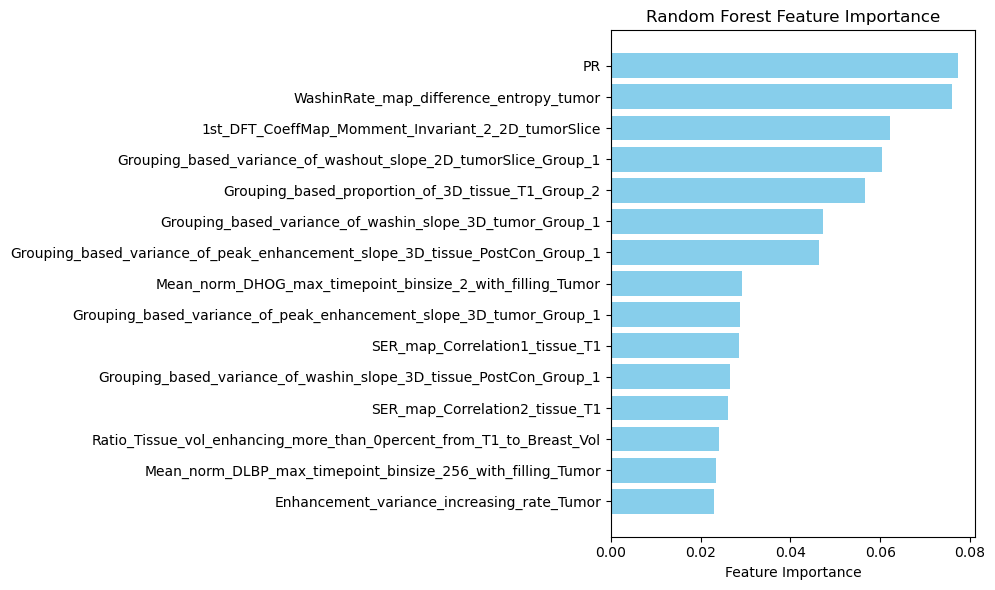

In [784]:
    
    if 1:
        # Create a DataFrame for feature importance
        importance_df = pd.DataFrame({
            'feature': pcols, 
            'importance': rf_model.feature_importances_
        })

        # Sort features by importance in descending order.
        importance_df.sort_values('importance', ascending=False, inplace=True)

        # Create a horizontal bar plot
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['feature'][:15], importance_df['importance'][:15], color='skyblue')
        plt.xlabel("Feature Importance")
        plt.title("Random Forest Feature Importance")
        plt.gca().invert_yaxis()  # Highest importance at the top
        plt.tight_layout()
        plt.show()
    